In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, accuracy_score
)
import numpy as np

In [2]:
# Load the dataset
malaria_data = pd.read_csv('malaria_outbreak.csv')

In [3]:
malaria_data

,Year,Rainfall,MinTemperature,MaxTemperature,RelativeHumidity_1(0800hrs),RelativeHumidity_2(1400hrs),MVP,MalarialCases,MalariaOutbreak
0,2006,0.0,20.00,28.36,67.74,66.39,135,217,no
1,2006,0.0,21.11,30.01,68.61,69.14,192,298,no
2,2006,1317.7,24.38,31.51,71.55,74.06,98,413,no
3,2006,2441.1,26.38,31.66,72.40,76.77,71,603,yes
4,2006,3743.1,27.18,32.67,74.35,77.03,108,636,yes
...,...,...,...,...,...,...,...,...,...
67,2011,7871.2,26.18,30.88,82.03,79.45,533,1371,yes
68,2011,2007.0,26.47,31.69,75.87,78.03,525,968,yes
69,2011,2315.6,29.73,33.17,65.26,67.42,590,537,yes
70,2011,79.2,23.08,31.68,63.26,65.42,635,425,yes


In [4]:
# Drop 'Year' and encode target variable
malaria_data = malaria_data.drop(columns=['Year'])
malaria_data['MalariaOutbreak'] = malaria_data['MalariaOutbreak'].map({'yes': 1, 'no': 0})


In [5]:
# Correlation Matrix
correlation_matrix = malaria_data.corr()


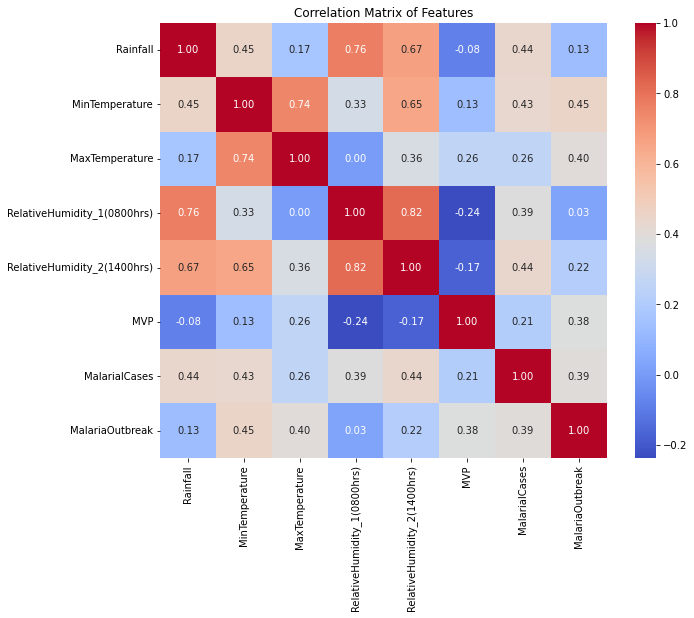

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

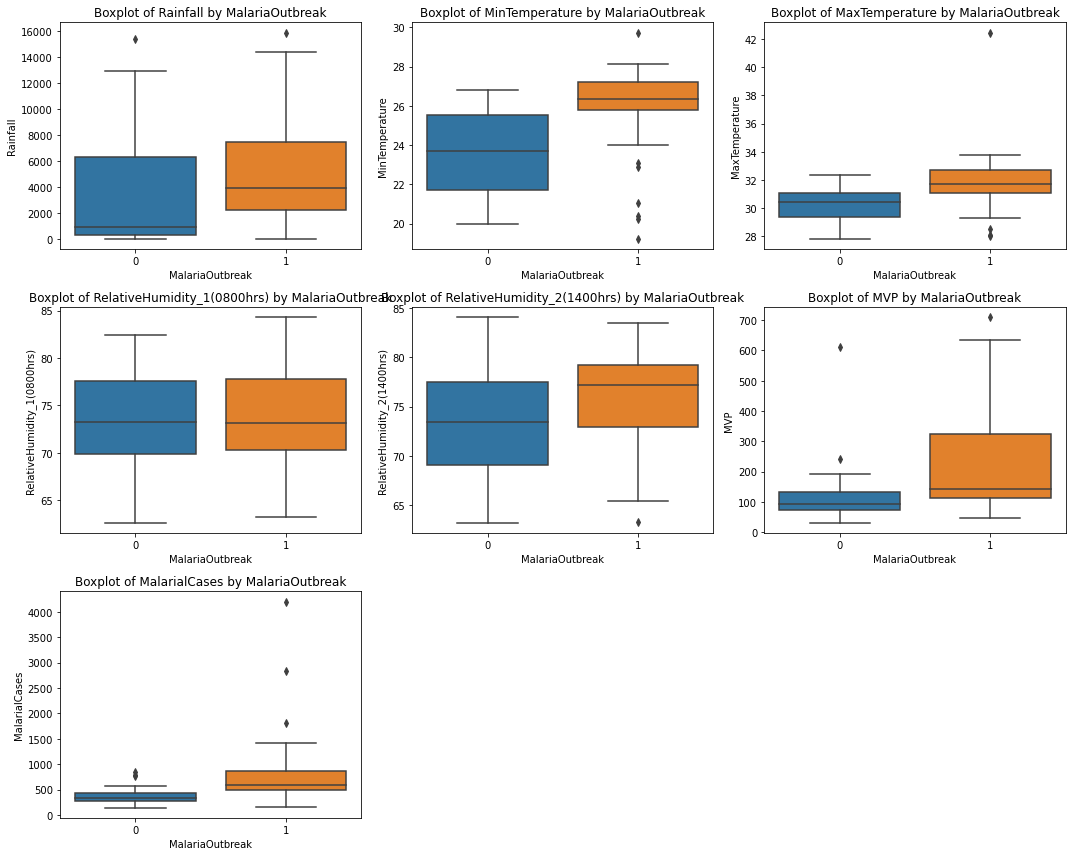

In [7]:
# Boxplots
features = malaria_data.drop(columns=['MalariaOutbreak']).columns
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=malaria_data, x='MalariaOutbreak', y=feature)
    plt.title(f"Boxplot of {feature} by MalariaOutbreak")
plt.tight_layout()
plt.show()

In [12]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Splitting data into training and testing sets
X = malaria_data.drop(columns=['MalariaOutbreak'])
y = malaria_data['MalariaOutbreak']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
# Initialize models
models = {
    #"Logistic Regression": LogisticRegression(random_state=42, max_iter=500, solver='lbfgs'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
}

In [19]:
logistic_model = LogisticRegression(random_state=42, max_iter=500, solver='lbfgs')  # Adjust max_iter
logistic_model.fit(X_train, y_train)


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, random_state=42)

In [20]:
y_pred = logistic_model.predict(X_test)
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]


In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

Logistic Regression Accuracy: 0.73


In [17]:
# Train models and make predictions
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results[model_name] = {
        "model": model,
        "y_pred": y_pred,
        "y_pred_prob": y_pred_prob,
        "accuracy": accuracy_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred),
    }

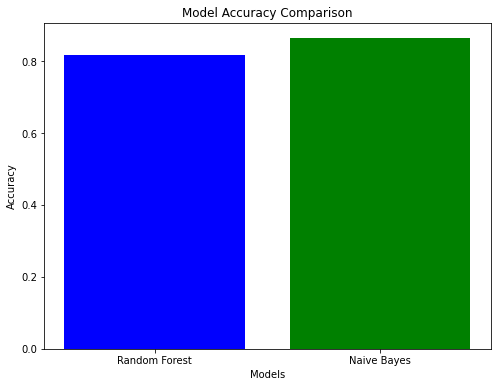

In [18]:
# Accuracy bar chart
accuracies = {model_name: result["accuracy"] for model_name, result in results.items()}
plt.figure(figsize=(8, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.show()

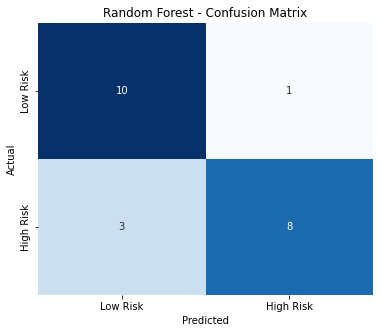

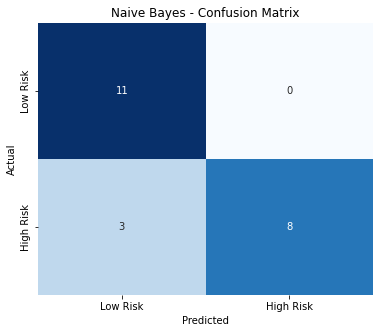

In [23]:
# Confusion Matrices
for model_name, result in results.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        result["conf_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Low Risk", "High Risk"],
        yticklabels=["Low Risk", "High Risk"],
    )
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

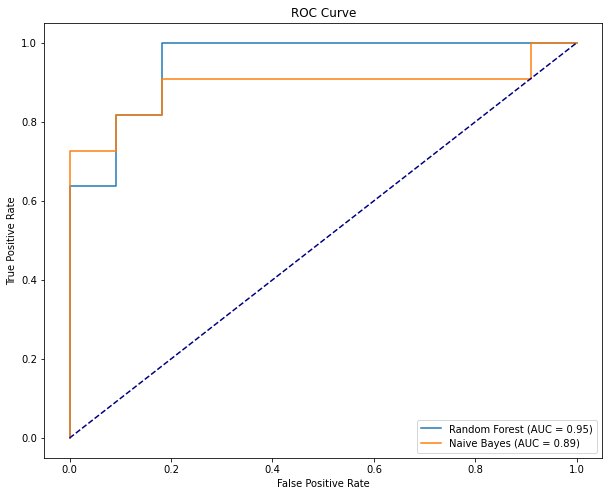

In [24]:
# ROC Curves
plt.figure(figsize=(10, 8))
for model_name, result in results.items():
    if result["y_pred_prob"] is not None:
        fpr, tpr, _ = roc_curve(y_test, result["y_pred_prob"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [25]:
# Evaluation Reports
for model_name, result in results.items():
    print(f"Evaluation Report for {model_name}:")
    print(classification_report(y_test, result["y_pred"], target_names=["Low Risk", "High Risk"]))
    print("-" * 60)

Evaluation Report for Random Forest:
              precision    recall  f1-score   support

    Low Risk       0.77      0.91      0.83        11
   High Risk       0.89      0.73      0.80        11

    accuracy                           0.82        22
   macro avg       0.83      0.82      0.82        22
weighted avg       0.83      0.82      0.82        22

------------------------------------------------------------
Evaluation Report for Naive Bayes:
              precision    recall  f1-score   support

    Low Risk       0.79      1.00      0.88        11
   High Risk       1.00      0.73      0.84        11

    accuracy                           0.86        22
   macro avg       0.89      0.86      0.86        22
weighted avg       0.89      0.86      0.86        22

------------------------------------------------------------


In [26]:
# Logistic Regression Evaluation Report
print("Evaluation Report for Logistic Regression:")
print(classification_report(y_test, y_pred, target_names=["Low Risk", "High Risk"]))

Evaluation Report for Logistic Regression:
              precision    recall  f1-score   support

    Low Risk       0.69      0.82      0.75        11
   High Risk       0.78      0.64      0.70        11

    accuracy                           0.73        22
   macro avg       0.74      0.73      0.72        22
weighted avg       0.74      0.73      0.72        22



In [27]:
import joblib

In [28]:
# Save the trained Naive Bayes model
joblib.dump(models["Naive Bayes"], "malaria_outbreak.pkl")
print("Naive Bayes model saved successfully.")

Naive Bayes model saved successfully.


In [29]:
print(models)

{'Random Forest': RandomForestClassifier(random_state=42), 'Naive Bayes': GaussianNB()}
